In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(path, split=0.1):
  images = sorted(glob(os.path.join(path, "images/*" )))
  masks = sorted(glob(os.path.join(path, "masks/*" )))

  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)

  #print(total_size, valid_size, test_size)

  train_x, valid_x = train_test_split(images, test_size = valid_size, random_state = 42)
  train_y, valid_y = train_test_split(masks, test_size = valid_size, random_state = 42)

  train_x, test_x = train_test_split(train_x, test_size = test_size, random_state = 42)
  train_y, test_y = train_test_split(train_y, test_size = test_size, random_state = 42)

  return(train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (256,256))
  x = x/255.0    
  return x

def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256,256))
  x = x/255.0
  x = np.expand_dims(x, axis = -1)    
  return x

def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([256, 256, 3])
  y.set_shape([256, 256, 1])

  return x, y

def tf_dataset(x, y, batch=8):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

In [ ]:
path = "/content/drive/MyDrive/Polyp Work/Dataset"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)
print(len(train_x), len(valid_x), len(test_x))

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Input, MaxPool2D, Concatenate
from tensorflow.keras.models import Model

In [ ]:
def conv_block(x, num_filters):
  x = Conv2D(num_filters, (3, 3), padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, (3, 3), padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def build_model():
  size = 256
  num_filters = [12,24,36,48]
  inputs = Input(shape=(size, size, 3))

  skip_x = []
  x = inputs

  for f in num_filters:
    x = conv_block(x, f)
    skip_x.append(x)
    x = MaxPool2D((2, 2))(x)

  x = conv_block(x, num_filters[-1])
  num_filters.reverse()
  skip_x.reverse()

  for i, f in enumerate(num_filters):
    x = UpSampling2D((2,2))(x)
    xs = skip_x[i]
    x = Concatenate()([x, xs])
    x = conv_block(x, f)

  x = Conv2D(1, (1, 1), padding = "same", name='my_last_Conv2D')(x)
  x = Activation("sigmoid")(x)

  return Model(inputs, x)

In [ ]:
model = build_model()
model.summary()

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    #x = (intersection + 1e-15) / (union + 1e-15)
    x = (2.0 * intersection + 1e-8) / (union + 1e-8)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
batch = 8
lr = 1e-4
epochs = 100

train_dataset = tf_dataset(train_x, train_y, batch = batch)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch)

opt = tf.keras.optimizers.Adam(lr)
metrics = ["acc", Recall(), Precision(), iou]
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = metrics)

callbacks = [ ModelCheckpoint("/content/drive/MyDrive/3_U_Net.h5"),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3),
    TensorBoard(),
    EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = False)
]


train_steps = len(train_x) // batch
valid_steps = len(valid_x) // batch

if len(train_x) % batch !=0:
    train_steps += 1

if len(valid_x) % batch !=0:
    valid_steps += 1
  
history = model.fit(
    train_dataset, 
    validation_data = valid_dataset,
    epochs = epochs,
    steps_per_epoch = train_steps,
    validation_steps = valid_steps,
    callbacks = callbacks,
    shuffle = False
  )

In [ ]:
model.save("/content/drive/MyDrive/3_U_Net.h5")

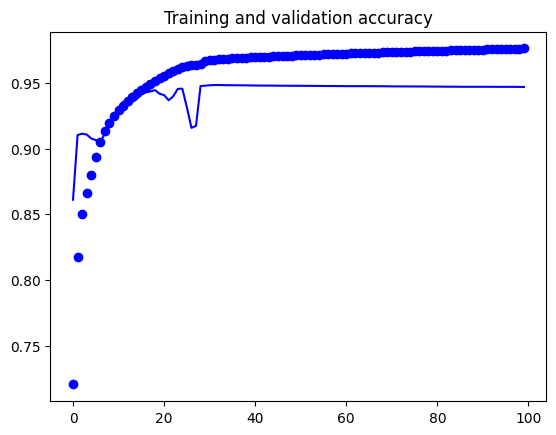

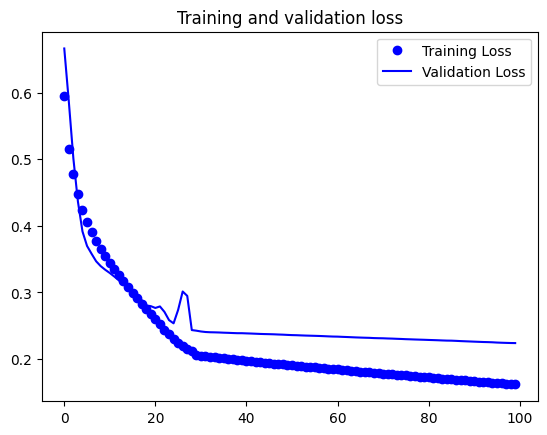

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
acc = history.history['acc'][-1]
loss = history.history['loss'][-1]
print('Training Accuracy:',acc);
print('Training loss:',loss)

Training Accuracy: 0.9762431383132935
Training loss: 0.1617708057165146


In [ ]:
batch = 16

In [ ]:
from tensorflow.keras.utils import CustomObjectScope

test_dataset = tf_dataset(test_x, test_y, batch = batch)
test_steps = len(test_x)//batch
if len(test_x) % batch != 0:
    test_steps += 1

with CustomObjectScope({'iou': iou}):
  model = tf.keras.models.load_model("/content/drive/MyDrive/2_U_Net.h5")
model.evaluate(test_dataset, steps = test_steps)

In [ ]:
def read_image(path):
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  y = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
  y = cv2.resize(y, (256,256))
  y = y/255.0
  x = cv2.resize(x, (256,256))
  x = x/255.0    #(256, 256, 3)
  return x, y

def read_mask(path):
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (256,256))
  x = np.expand_dims(x, axis = -1)    #(256, 256, 1)
  return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [ ]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
from tqdm import tqdm
for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total = len(test_x)):
        x, rgb_img = read_image(x)
        y = read_mask(y)
                
        y_pred = model.predict(np.expand_dims(x, axis = 0))
        y_pred = y_pred[0] > 0.5
        h, w, _ = x.shape
        
        #x = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        white_line = np.ones((h, 10, 3)) * 255.0
        
        all_images = [
            rgb_img, white_line, 
            mask_parse(y), white_line,
            mask_parse(y_pred) * 255.0
        ]
        
        image = np.concatenate(all_images, axis = 1)
        
        plt.imshow(image)
        plt.show()
        cv2.imwrite(f"/content/drive/MyDrive/UNet_colorectal_polyp_classification /result/new1/{i}.png", image)

In [ ]:
pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
img_path = '/content/drive/MyDrive/Polyp Work/Dataset/images/1.png'

In [ ]:
from PIL import Image

def preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img = img.resize(target_size)
    x = np.array(img)
    return x

In [ ]:
from keract import get_activations
x = np.expand_dims(x, axis=0)
#x = np.squeeze(x, axis=0)
activations = get_activations(model, x)

In [ ]:
from keract import display_activations
display_activations(activations, save=False)